<CENTER><B>Identifying the Predictors of Water Pump Failure in Tanzania</B></CENTER>
## Introduction

### Research Question:
What are the best predictors of water pump failure?
### Variables:
Using data from Taarifa and the Tanzanian Ministry of Water, the goal is to predict which pumps are functional, which need some repairs, and which don’t work at all. This study will identify the best predictors based on a number of variables such as what kind of pump is operating, when it was installed, and how it is managed. 
### Motivation:
An understanding of which water pumps will fail can improve maintenance operations and ensure that clean, potable water is available to communities across Tanzania.


In [65]:
#from pandas import Series, DataFrame
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline

from sklearn.cross_validation import train_test_split
from sklearn.linear_model import LassoLarsCV

import warnings
warnings.filterwarnings('ignore')

In [66]:
#Load the datasets
ind_vars = pd.read_csv("D:\Data\WeyCapstone\Competition\indep_variables.csv")
dep_vars = pd.read_csv("D:\Data\WeyCapstone\Competition\dep_variable.csv")
#test_vars = pd.read_csv("D:\Data\WeyCapstone\Competition\testing_variables.csv")

## Methods

### Sample

This is an intermediate-level practice competition hosted by DRIVENDATA to come up with the best statistical model for difficult predictive problems that make a difference in the world.  The data has already been split into training and test data sets to be used in the competition.  The test data will be used to validate the model.

The population is pump locations provided by the Tanzanian Ministry of Water.  The sample training set consists of 59400 entries which each represent a pump.  The dependent or target variable is the status of the pump, as functional or non-functional.

### Measures

The potentional independent variables are:

In [67]:
ind_vars.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 59400 entries, 0 to 59399
Data columns (total 40 columns):
id                       59400 non-null int64
amount_tsh               59400 non-null float64
date_recorded            59400 non-null object
funder                   55765 non-null object
gps_height               59400 non-null int64
installer                55745 non-null object
longitude                59400 non-null float64
latitude                 59400 non-null float64
wpt_name                 59400 non-null object
num_private              59400 non-null int64
basin                    59400 non-null object
subvillage               59029 non-null object
region                   59400 non-null object
region_code              59400 non-null int64
district_code            59400 non-null int64
lga                      59400 non-null object
ward                     59400 non-null object
population               59400 non-null int64
public_meeting           56066 non-null object
r

The dependent variable is status consisting of three levels as follows:

In [68]:
dep_vars.groupby('status_group').count()

id
status_group                  
functional               32259
functional needs repair   4317
non functional           22824

The dependent variable was recoded as 0 and 1, where 1 indicated non functional.

In [69]:
dep_vars['status_group_nbr'] = 0
dep_vars['status_group_nbr'][(dep_vars['status_group']== 'non functional')] = 1
dep_vars.groupby('status_group_nbr').count()

id  status_group
status_group_nbr                     
0                 36576         36576
1                 22824         22824

In [70]:
# Add the dependent variable to the end of the indep variables file
ind_vars['status_group_nbr']=dep_vars['status_group_nbr']
# ind_vars.info()

#### Data Management

All the column names were converted to lowercase.

In [71]:
#Make sure all columns are lower-case 
ind_clean.columns = map(str.lower, ind_clean.columns)

Independent variables were selected and standardized to have a mean of 0 and a standard deviation of 1.

In [72]:
# select predictor variables and target variable as separate data sets  
predvar= ind_clean[['gps_height','population','construction_year']]

predictors=predvar.copy()
from sklearn import preprocessing
#predictors['longitude']=preprocessing.scale(predictors['longitude'].astype('float64'))
#predictors['latitude']=preprocessing.scale(predictors['latitude'].astype('float64'))
predictors['gps_height']=preprocessing.scale(predictors['gps_height'].astype('float64'))
predictors['population']=preprocessing.scale(predictors['population'].astype('float64'))
predictors['construction_year']=preprocessing.scale(predictors['construction_year'].astype('float64'))

In [73]:
# Target
target = ind_clean.status_group_nbr

The sample was divided into a training and testing set using a 70 / 30 split.  

In [74]:
pred_train, pred_test, tar_train, tar_test = train_test_split(predictors, target,  test_size=.3, random_state=123)

In [75]:
print (pred_train.shape)
print (pred_test.shape)
print (tar_train.shape)
print (tar_test.shape)

(19469, 3)
(8344, 3)
(19469,)
(8344,)


### Analysis
Least absolute shrinkage and selection operator (LASSO)regression was selected for this analysis. LASSO is a regression analysis method that performs both variable selection and regularization in order to enhance the prediction accuracy and interpretability of the statistical model it produces. 10-fold cross-validation was used.  Cross-validation is a technique to evaluate predictive models by partitioning the original sample into a training set to train the model, and a test set to evaluate it. In k-fold cross-validation, the original sample is randomly partitioned into k equal size subsamples. Of the k subsamples, a single subsample is retained as the validation data for testing the model, and the remaining k-1 subsamples are used as training data. The cross-validation process is then repeated k times (the folds), with each of the k subsamples used exactly once as the validation data. The k results from the folds can then be averaged (or otherwise combined) to produce a single estimation. The advantage of this method is that all observations are used for both training and validation, and each observation is used for validation exactly once.

## Results

In [76]:
# specify the lasso regression model
model=LassoLarsCV(cv=10, precompute=False).fit(pred_train,tar_train)

In [77]:
# print variable names and regression coefficients
dict(zip(predictors.columns, model.coef_))

{'construction_year': -0.033937152143022661,
 'gps_height': -0.064971250574572662,
 'population': 0.0097900692765477571}

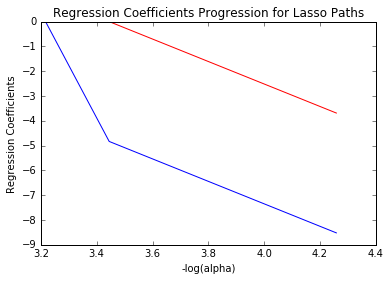

In [78]:
# plot coefficient progression
m_log_alphas = -np.log10(model.alphas_)
ax = plt.gca()
plt.plot(m_log_alphas, model.coef_path_.T)
plt.axvline(-np.log10(model.alpha_), linestyle='--', color='k',
            label='alpha CV')
plt.ylabel('Regression Coefficients')
plt.xlabel('-log(alpha)')
plt.title('Regression Coefficients Progression for Lasso Paths')

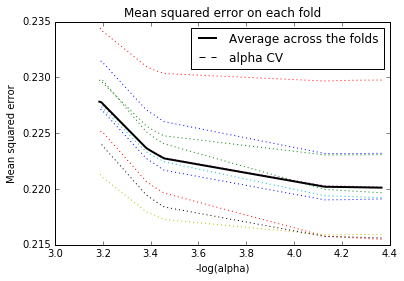

In [79]:
# plot mean square error for each fold
m_log_alphascv = -np.log10(model.cv_alphas_)
plt.figure()
plt.plot(m_log_alphascv, model.cv_mse_path_, ':')
plt.plot(m_log_alphascv, model.cv_mse_path_.mean(axis=-1), 'k',
         label='Average across the folds', linewidth=2)
plt.axvline(-np.log10(model.alpha_), linestyle='--', color='k',
            label='alpha CV')
plt.legend()
plt.xlabel('-log(alpha)')
plt.ylabel('Mean squared error')
plt.title('Mean squared error on each fold')

In [80]:
# MSE from training and test data
from sklearn.metrics import mean_squared_error
train_error = mean_squared_error(tar_train, model.predict(pred_train))
test_error = mean_squared_error(tar_test, model.predict(pred_test))
print ('training data MSE')
print(train_error)
print ('test data MSE')
print(test_error)

training data MSE
0.219901392644
test data MSE
0.21844298091


In [81]:
# R-square from training and test data
rsquared_train=model.score(pred_train,tar_train)
rsquared_test=model.score(pred_test,tar_test)
print ('training data R-square')
print(rsquared_train)
print ('test data R-square')
print(rsquared_test)

training data R-square
0.0346290362392
test data R-square
0.0383771493918
